# Perceptron

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target==0) #onlu Iris-setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X,y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Perceptron 클래스는 매개변수가
loss="perceptron", learning_rate="constant", eta=1, penalty=None인
SGDClassifier와 같음

## 다층 퍼셉트론으로 논리 연산 구현하기

In [ ]:
w11 = np.array([-2, -2])
w12 = np.array([2, 2])
w2 = np.array([1, 1])
b1 = 3
b2 = -1
b3 = -1

In [ ]:
def MLP(x, w, b):
    y = np.sum(w*x)+b
    if y<=0:
        return 0
    else:
        return 1

In [ ]:
def NAND(x1, x2):
    return MLP(np.array([x1, x2]), w11, b1)

def OR(x1, x2):
    return MLP(np.array([x1, x2]), w12, b2)

def AND(x1, x2):
    return MLP(np.array([x1, x2]), w2, b3)

def XOR(x1, x2):
    return AND(NAND(x1, x2), OR(x1, x2))

In [ ]:
for x in [(0, 0), (1, 0), (0, 1), (1, 1)]:
    y = XOR(x[0], x[1])
    print("입력 값: " + str(x) + "출력값: " + str(y))

입력 값: (0, 0)출력값: 0
입력 값: (1, 0)출력값: 1
입력 값: (0, 1)출력값: 1
입력 값: (1, 1)출력값: 0


# 시퀀셜 API로 이미지 분류기 만들기

# 케라스로 데이터셋 적재하기

In [ ]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
X_train.shape

(55000, 28, 28)

In [ ]:
X_train.dtype

dtype('uint8')

In [ ]:
#픽셀 강도 변환
X_train, X_valid, X_test = X_train/255., X_valid/255., X_test/255.

In [ ]:
#패션 MNIST에서는 레이블에 해당하는 아이템을 나타내기 위해 클래스 이름의 리스트 생성필요
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
class_names[y_train[0]]

'Ankle boot'

## 시퀀셜 API로 모델 만들기

In [ ]:
# 두 개의 은닉 층으로 이루어진 분류용 다층 퍼셉트론

#결과를 재현하기 위해 텐서플로의 랜덤 시드 설정
tf.random.set_seed(42)

#Sequential 모델 만들기 - 가장 간단한 케라스의 신경망 모델
# 순서대로 연결 된 층을 일렬로 쌓아 구성 -> Sequential API
model = tf.keras.Sequential()

#첫번째 은닉층 추가 - 배치 크기는 포함하지 않고 샘플의 크기만 담은 shape 매개변수 지정
# 케라스는 입력의 크기를 통해 첫 번째 은닉 층의 연결 가중치 행렬의 크기 지정
model.add(tf.keras.layers.Input(shape = [28,28]))

#Flatten 층 추가 - 각 입력 이미지를 1D 배열로 변화 (간단한 전처리)
model.add(tf.keras.layers.Flatten())

#뉴런 300개를 가진 Dense 은닉층 추가 -> ReLU 활성화 함수를 사용해 가중치 행렬을 관리
# 가중치 행렬: 층의 뉴런과 입력 사이의 모든 연결 가중치 포함, 편향(뉴런마다 하나씩 존재)도 벡터로 관리
model.add(tf.keras.layers.Dense(300, activation="relu"))

#뉴런 100개를 가진 두번째 Dense 은닉층 추가
model.add(tf.keras.layers.Dense(100, activation="relu"))

#뉴런 10개(클래스마다 하나씩)를 가진 Dense 출력 층 추가
# 배타적인 클래스이기 때문에 소프트맥스 활성화 함수 사용
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
#좀 더 간단히 층의 리스트를 전달해 Sequential 모델 만들기

# 세션을 지워 이름 타운터 재설정
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#모델에 있는 모든 층을 출력 - 이름, 출력 크기, 파라미터 개수
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#층의 목록
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [ ]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [ ]:
model.get_layer('dense') is hidden1

True

In [ ]:
#층의 모든 파라미터 접근
weights, biases = hidden1.get_weights()

In [ ]:
weights

array([[-0.05174913, -0.01247165,  0.06817001, ...,  0.01141658,
         0.00345372,  0.05564611],
       [ 0.04251325,  0.01469216, -0.06117823, ..., -0.00701921,
        -0.0587615 ,  0.05432427],
       [-0.00734902,  0.00653707,  0.02850188, ...,  0.02581704,
        -0.04022149, -0.05947123],
       ...,
       [ 0.01280881, -0.00595811,  0.06241973, ...,  0.05824238,
        -0.0070271 , -0.02852426],
       [-0.06962413,  0.07003661,  0.06389384, ...,  0.02618857,
        -0.02419278,  0.0087515 ],
       [-0.06067907,  0.0644688 ,  0.04912419, ..., -0.06515944,
         0.01382882,  0.03526624]], dtype=float32)

In [ ]:
weights.shape

(784, 300)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
biases.shape

(300,)

## 모델 컴파일

In [ ]:
#사용할 손실 함수와 옵티마이저 지정
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

## 모델 훈련과 평가

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data = (X_valid, y_valid))

Epoch 1/30
1598/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6670 - loss: 1.0685

KeyboardInterrupt: 

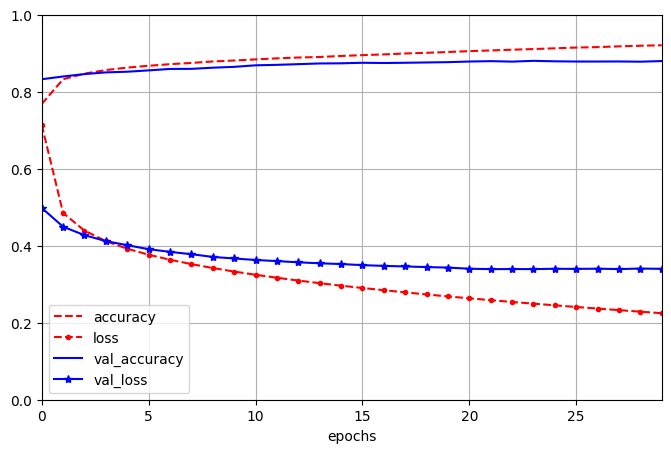

In [ ]:
#학습 곡선 확인하기
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="epochs",
    style=["r--", "r--.", "b-", "b-*"]
)
plt.show()

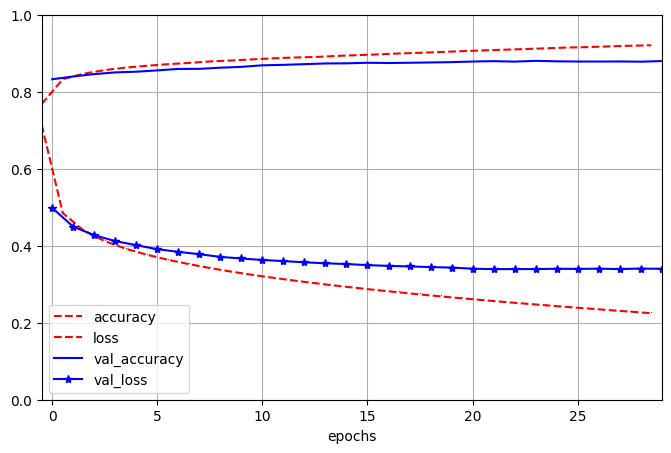

In [ ]:
#검증 손실은 에포크가 끝난 후에 계산되고 훈련 손실은 에포크가 진행됨에 따라 계산
# -> 훈련 곡선은 에포크의 절반만큼 왼쪽으로 이동해야 함
import numpy as np
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--,", "b-", "b-*"]):
  epochs = np.array(history.epoch)+(0 if key.startswith("val_") else -0.5)
  plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("epochs")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [ ]:
#테스트 세트로 모델 평가해 일반화 오차 추정하기
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8745 - loss: 0.3621


[0.3576326072216034, 0.8752999901771545]

## 모델로 예측 만들기

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.24, 0.01, 0.53],
       [0.  , 0.  , 0.85, 0.  , 0.01, 0.  , 0.14, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [ ]:
import numpy as np
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [ ]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [ ]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

# 시퀀셜 API로 회귀용 다층 퍼셉트론 만들기

In [77]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

In [79]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape = X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train) #Normalization 층을 사용하기 때문에 훈련 데이터에 적응시키는 작업
history = model.fit(X_train, y_train, epochs=20,
                    validation_data = (X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.0475 - root_mean_squared_error: 1.0235 - val_loss: 0.4362 - val_root_mean_squared_error: 0.6605
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3766 - root_mean_squared_error: 0.6137 - val_loss: 1.4291 - val_root_mean_squared_error: 1.1954
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3643 - root_mean_squared_error: 0.6035 - val_loss: 0.3974 - val_root_mean_squared_error: 0.6304
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3408 - root_mean_squared_error: 0.5838 - val_loss: 0.8917 - val_root_mean_squared_error: 0.9443
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3308 - root_mean_squared_error: 0.5751 - val_loss: 4.6879 - val_root_mean_squared_error: 2.1652
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3651 - root_mean_squared_error: 0.6043 - val_loss: 0.6777 - val_

1/1 [==============================] - 1s 756ms/step


In [80]:
rmse_test

0.5348725914955139

In [81]:
y_pred

array([[0.4315554],
       [1.0372338],
       [5.0207553]], dtype=float32)

# 함수형 API로 복잡한 모델 만들기

In [107]:
#이름 카운터 재설정
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [108]:
import tensorflow as tf

normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

#Input 객체 생성 - 모델이 받을 입력의 종류에 대한 사양, input과 선택적으로 dtype 매개변수를 가짐
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])

#normalize 층을 함수처럼 Input 객체를 전달
# -> 심볼릭 입력
normalized = normalization_layer(input_)

#층을 순차적으로 연결
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)

#입력과 두번째 은닉층의 출력을 연결
concat = concat_layer([normalized, hidden2])

#최종 output 생성
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [109]:
X_train.shape[1:]

(8,)

In [110]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

In [111]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.1455 - root_mean_squared_error: 1.0703 - val_loss: 0.7989 - val_root_mean_squared_error: 0.8938
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - root_mean_squared_error: 0.6766 - val_loss: 0.4227 - val_root_mean_squared_error: 0.6502
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3987 - root_mean_squared_error: 0.6314 - val_loss: 0.4071 - val_root_mean_squared_error: 0.6380
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3811 - root_mean_squared_error: 0.6174 - val_loss: 0.4180 - val_root_mean_squared_error: 0.6466
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3685 - root_mean_squared_error: 0.6070 - val_loss: 0.3676 - val_root_mean_squared_error: 0.6063
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3611 - root_mean_squared_error: 0.6009 - val_loss: 0.8127 - val_

In [112]:
tf.random.set_seed(42)

In [113]:
# 일부 특성을 짧은 경로로 전달하고 다른 특성들을 깊은 경로로 전달하고 싶을 경우
input_wide = tf.keras.layers.Input(shape=[5])
input_deep = tf.keras.layers.Input(shape=[6])
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)

# Concatenate 층을 만들고 주어진 입력으로 이 층을 호출
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)

#두 개의 입력 존재
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [114]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

In [116]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data = ((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3269 - root_mean_squared_error: 0.5718 - val_loss: 0.5327 - val_root_mean_squared_error: 0.7299
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3247 - root_mean_squared_error: 0.5698 - val_loss: 0.5887 - val_root_mean_squared_error: 0.7673
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3226 - root_mean_squared_error: 0.5679 - val_loss: 0.3148 - val_root_mean_squared_error: 0.5611
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3203 - root_mean_squared_error: 0.5660 - val_loss: 0.3196 - val_root_mean_squared_error: 0.5653
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3199 - root_mean_squared_error: 0.5656 - val_loss: 0.3413 - val_root_mean_squared_error: 0.5842
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3154 - root_mean_squared_error: 0.5616 - val_loss: 0.5665 - val_

In [124]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [122]:
#위의 코드와 똑같음

input_wide = tf.keras.layers.Input(shape=[5])
input_deep = tf.keras.layers.Input(shape=[6])
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation='relu')(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])

#규제를 위한 보조 출력 부분
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [125]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 6)                    13        ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 30)                   210       ['normalization_1[0][0]'] 

In [126]:
#모델의 손실가중치를 지정
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

In [127]:
#각 출력에 대한 레이블을 제공
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data = ((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 592, in update_state
        self.build(y_pred, y_true)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 521, in build
        self._set_metric_names()
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 547, in _set_metric_names
        raise ValueError(

    ValueError: Found two metrics with the same name: dense_2_root_mean_squared_error. All the metrics added to the model need to have unique names.


In [128]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test),
                               return_dict=True)

#케라스는 개별 손실과 측정 지표, 손실의 가중치 합을 반환
weighted_sum_of_losses, main_rmse, aux_rmse = eval_results

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1920, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 592, in update_state
        self.build(y_pred, y_true)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 521, in build
        self._set_metric_names()
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 547, in _set_metric_names
        raise ValueError(

    ValueError: Found two metrics with the same name: dense_2_dense_2_root_mean_squared_error. All the metrics added to the model need to have unique names.


In [129]:
# 각 출력에 대한 예측 반환
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 80ms/step


In [130]:
#딕셔너리 반환을 위해 딕셔너리 만들기
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 26ms/step


# 서브클래싱 API로 동적 모델 만들기

In [131]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [136]:
#Model 클래스를 상속한 다음 생성자 안에서 필요한 층을 생성
#WideAndDeepModel 클래스의 인스턴스는 위의 함수형 API로 만든 모델과 동일한 기능 수행
import keras

@keras.saving.register_keras_serializable()
class WideAndDeepModel(tf.keras.Model):
  def __init__(self, units=30, activation="relu", **kwargs):
    super().__init__(**kwargs) #모델에 이름을 부여하기 위해
    self.norm_layer_wide = tf.keras.layers.Normalization()
    self.norm_layer_deep = tf.keras.layers.Normalization()
    self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
    self.main_output = tf.keras.layers.Dense(1)
    self.aux_output = tf.keras.layers.Dense(1)

  def call(self, inputs):
    input_wide, input_deep = inputs
    norm_wide = self.norm_layer_wide(input_wide)
    norm_deep = self.norm_layer_deep(input_deep)
    hidden1 = self.hidden1(norm_deep)
    hidden2 = self.hidden2(hidden1)
    concat = tf.keras.layers.concatenate([norm_wide, hidden2])
    output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)
    return output, aux_output

tf.random.set_seed(42)
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [137]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics = ["RootMeanSquaredError", "RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_rmse, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10


AttributeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filewh8ekgw1.py", line 14, in tf__call
        hidden2 = ag__.converted_call(ag__.ld(self).hidden2, (ag__.ld(hidden1),), None, fscope)

    AttributeError: Exception encountered when calling layer 'my_cool_model' (type WideAndDeepModel).
    
    in user code:
    
        File "<ipython-input-136-077cee84cc23>", line 20, in call  *
            hidden2 = self.hidden2(hidden1)
    
        AttributeError: 'WideAndDeepModel' object has no attribute 'hidden2'
    
    
    Call arguments received by layer 'my_cool_model' (type WideAndDeepModel):
      • inputs=('tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)')


# 모델 저장과 복원하기

In [ ]:
model.save("my_keras_model", save_format="tf")